In [1]:
# Initial registration
import pandas as pd
import iss_preprocess as iss
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from itertools import cycle

2022-02-01 13:57:15,473 [INFO] WRITING LOG OUTPUT TO /camp/home/znamenp/.cellpose/run.log


In [2]:
ops = {
    'tile_reg_fraction': 0.1,  # fraction of border pixels to use for stitching
    'normalization': 'phase',  # phase correlation normalization
    'max_orthogonal_shift': 5,  # max allowed shift value before defaulting to 0
    'ch_to_align': 0,  # channel to use for registration between rounds
    'spot_threshold': 20,  # threshold for initial spot detection
    'omp_tol': 0.1,  # tolerance threshold for OMP algorithm
    'include_cycles': np.arange(7)  # cycles to include for basecalling and OMP
}

In [4]:
data_dir = Path(
    '/camp/lab/znamenskiyp/home/shared/projects/rabies_BARseq/BRAC6246.1b/brain/slide_006/section_02/sequencing_cycles')
fnames = [
    'section_02_cycle_01.czi',
    'section_02_cycle_02.czi',
    'section_02_cycle_03_03.czi',
    'section_02_cycle_04_2trk.czi',
    'section_02_cycle_05_2trk.czi',
    'section_02_cycle_06_2trk.czi',
    'section_02_cycle_07_2trk.czi',
    'section_02_cycle_08_2trk.czi'
]
# load stacks that contain both tracks
stacks = []
for i, fname in enumerate(fnames):
    tiles, metadata = iss.io.get_tiles(data_dir / fname)
    tiles = iss.image.correct_offset(tiles, method='metadata', metadata=metadata)
    im, tile_pos = iss.reg.register_tiles(
        tiles,
        reg_fraction=ops['tile_reg_fraction'],
        method='custom',
        max_shift=20
    )
    im = iss.io.reorder_channels(im, metadata)
    stacks.append(np.mean(im, axis=3))

# register sequencing rounds
corrected_stacks = iss.image.correct_levels(stacks, stacks[0][:, :, 0], method='histogram')

In [11]:
registered_stacks = register_rounds(
    corrected_stacks,
    ch_to_align=ops['ch_to_align'],
    filter_window='cosine',
    dog_filter=(10, 200)
)

registered_stacks = np.moveaxis(registered_stacks, 0, 2)
# save output
for i in range(registered_stacks.shape[2]):
    iss.io.write_stack(
        registered_stacks[:, :, i, :].squeeze(),
        f'/camp/home/znamenp/home/users/znamenp/tmp/stack_mean_{i}.tif'
    )

In [12]:
registered_stacks = iss.reg.register_rounds_fine(registered_stacks, tile_size=512)


/camp/home/znamenp/.conda/envs/iss-preprocess/lib/python3.9/site-packages/skimage/registration/_phase_cross_correlation.py:107: RuntimeWarning: invalid value encountered in cdouble_scalars
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\


In [13]:
for i in range(registered_stacks.shape[2]):
    iss.io.write_stack(
        registered_stacks[:, :, i, :].squeeze(),
        f'/camp/home/znamenp/home/users/znamenp/tmp/stack_mean_{i}.tif'
    )

In [3]:
from skimage.io import ImageCollection

coll = ImageCollection('/camp/home/znamenp/home/users/znamenp/tmp/stack_mean_*.tif')
stack = coll.concatenate()
stack = np.moveaxis(stack, 0, 2)
stack = stack.reshape([stack.shape[0], stack.shape[1], -1, 4])

In [14]:
stack = registered_stacks

In [4]:
stack.shape

(7625, 7654, 8, 4)


            This normally occurs when an ROI is not imaged on all rounds.
            Corresponding values of the fluorescence matrix will be set to NaN.
            


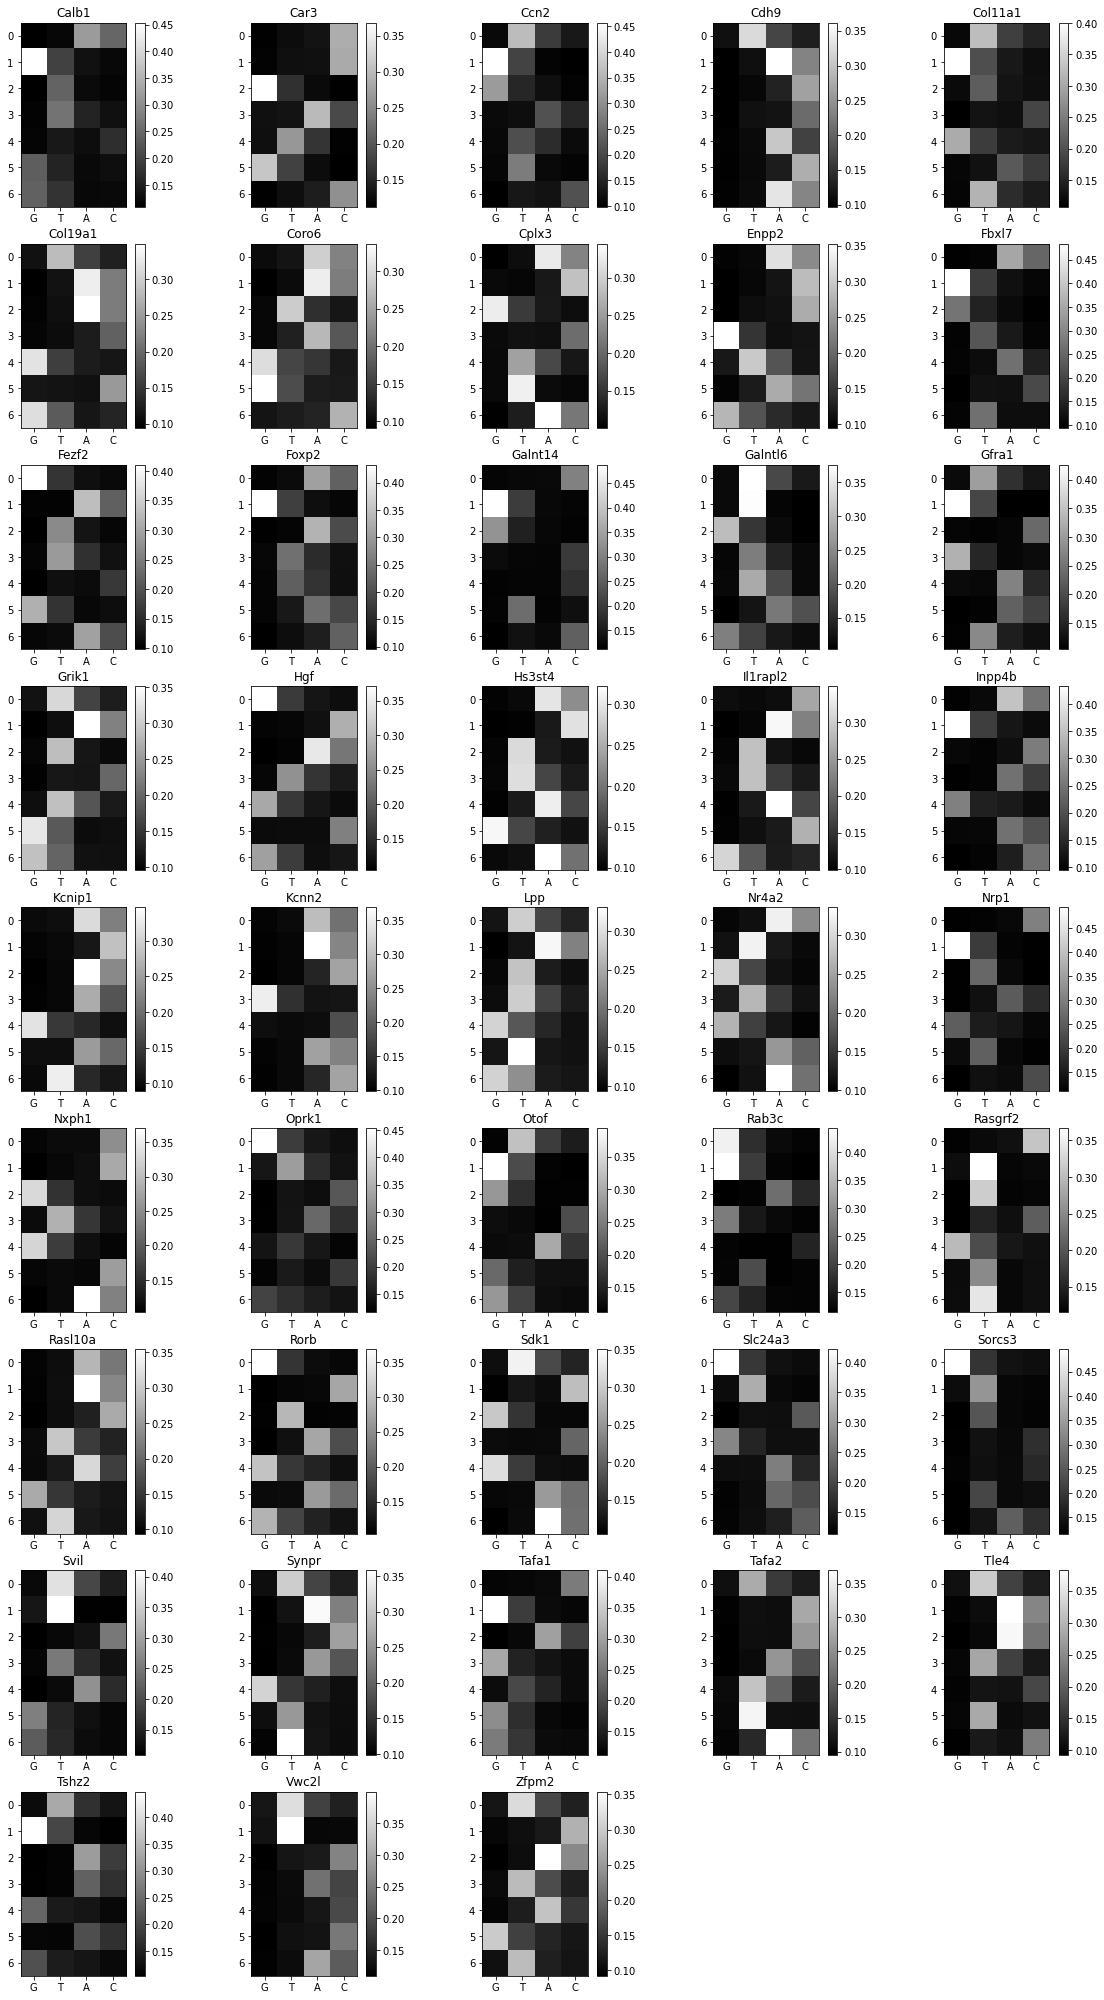

In [4]:
# Run OMP on the substack
spots = iss.segment.detect_spots(
    stack[:, :, 0, :].squeeze(),
    method='trackpy',
    threshold=ops['spot_threshold']
)
rois = iss.call.extract_spots(spots, stack[:, :, ops['include_cycles'], :])
codebook = pd.read_csv(
    '../iss_preprocess/call/codebook_YS220.csv',
    header=0,
    names=['gii', 'seq', 'gene']
)
gene_dict, unique_genes = iss.call.make_gene_templates(rois, codebook)

# Visualize the gene dictionary
plt.figure(figsize=(20, 40))
for igene, gene in enumerate(unique_genes):
    plt.subplot(10, 5, igene + 1)
    plt.imshow(np.reshape(gene_dict[:, igene], (7, 4)), cmap='gray')
    plt.title(gene)
    plt.colorbar()
    plt.xticks(np.arange(4), iss.call.BASES)

In [5]:
g, b, r = iss.call.run_omp(
    stack[:, :, ops['include_cycles'], :],
    gene_dict,
    tol=0.05
)

finished row 0 of 7625
finished row 1700 of 7625
finished row 3400 of 7625
finished row 5100 of 7625
finished row 6800 of 7625
finished row 1300 of 7625
finished row 4700 of 7625
finished row 3000 of 7625
finished row 6400 of 7625
finished row 4300 of 7625
finished row 6000 of 7625
finished row 2600 of 7625
finished row 900 of 7625
finished row 500 of 7625
finished row 3900 of 7625
finished row 2200 of 7625
finished row 3500 of 7625
finished row 5600 of 7625
finished row 7300 of 7625
finished row 1400 of 7625
finished row 6900 of 7625
finished row 1800 of 7625
finished row 5200 of 7625
finished row 4800 of 7625
finished row 4400 of 7625
finished row 100 of 7625
finished row 6100 of 7625
finished row 2700 of 7625
finished row 3100 of 7625
finished row 4000 of 7625
finished row 1000 of 7625
finished row 6500 of 7625
finished row 3600 of 7625
finished row 2300 of 7625
finished row 600 of 7625
finished row 1500 of 7625
finished row 5700 of 7625
finished row 5300 of 7625
finished row 7400 o

In [6]:
iss.io.write_stack((g-np.min(g)), '/camp/lab/znamenskiyp/home/users/znamenp/tmp/genes_0.05.tif', bigtiff=True)

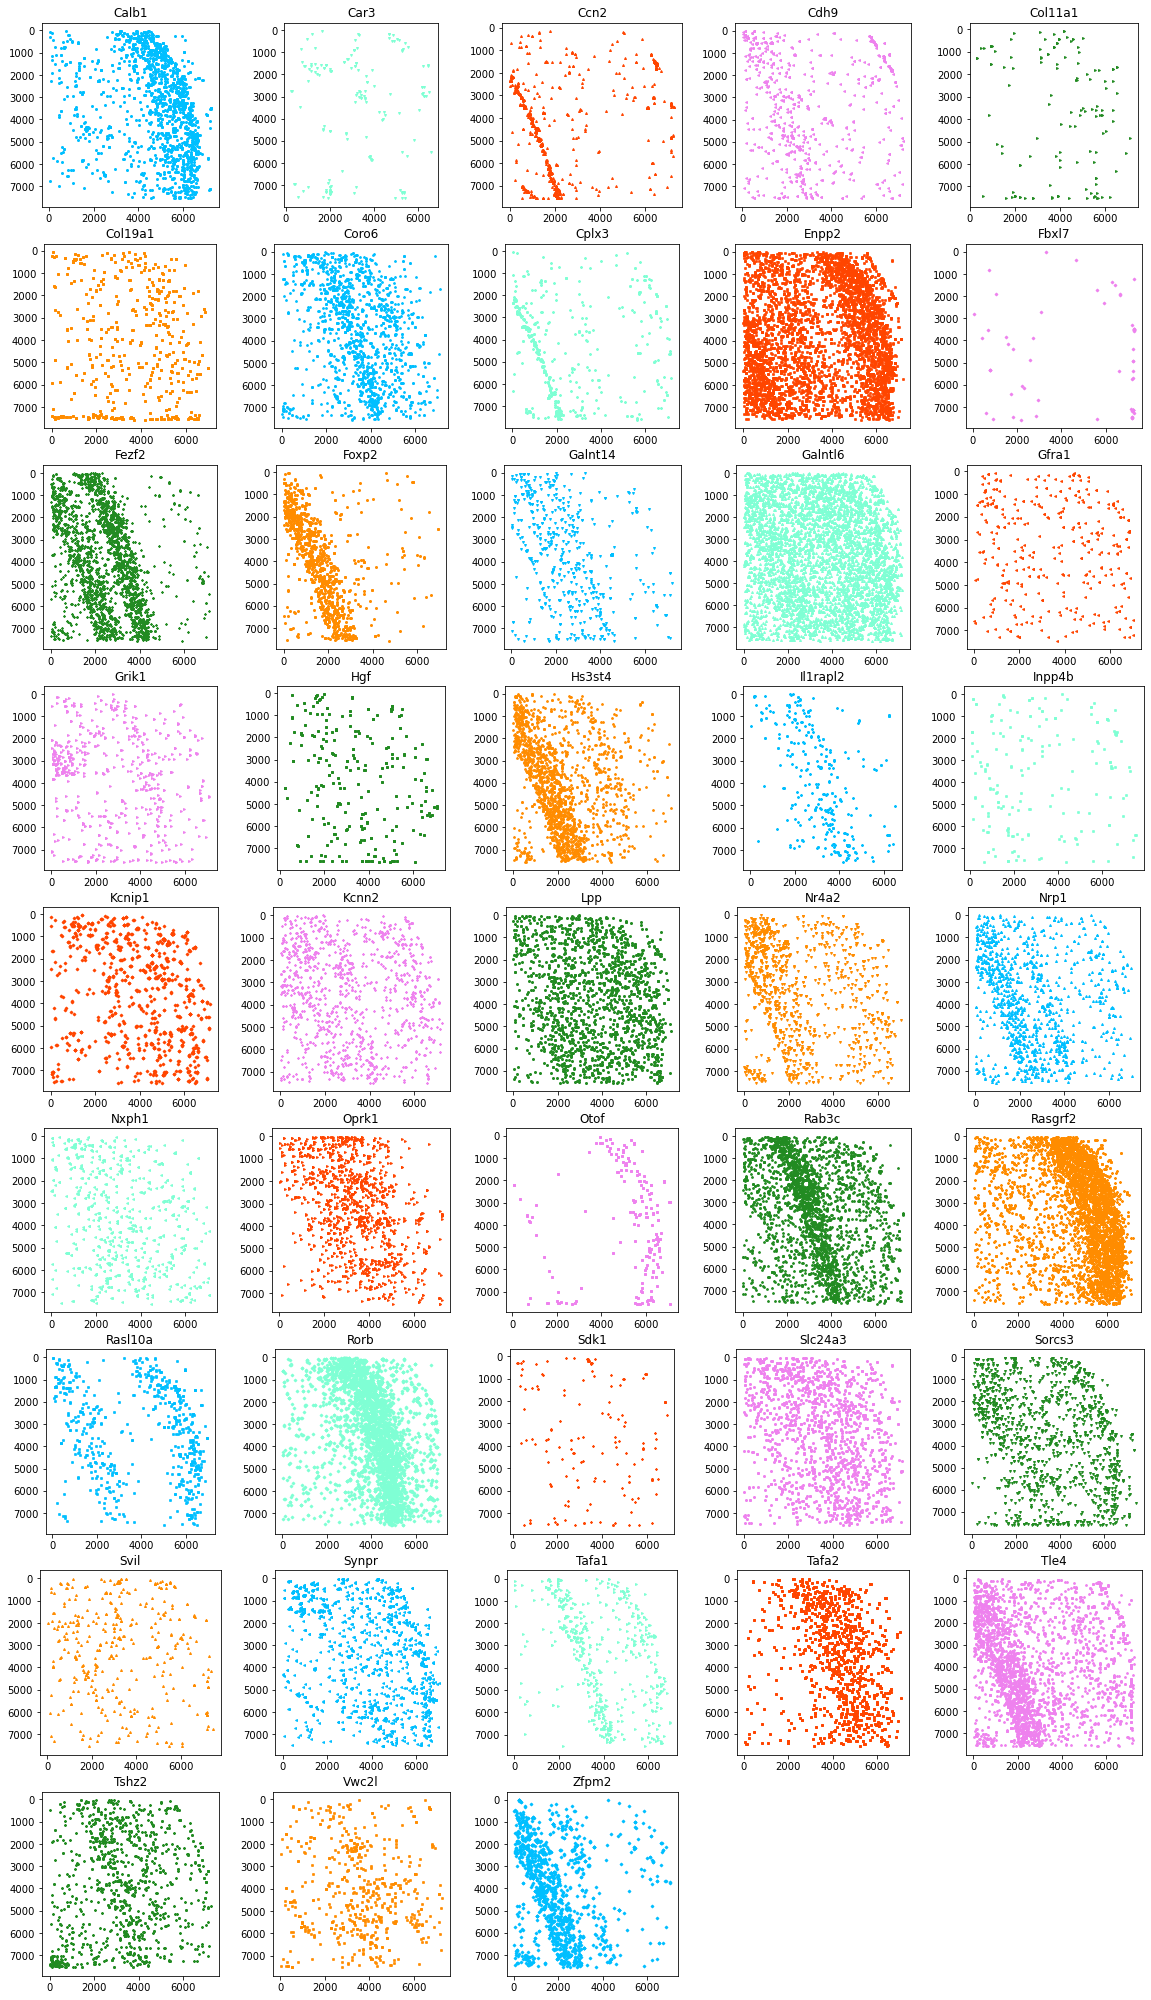

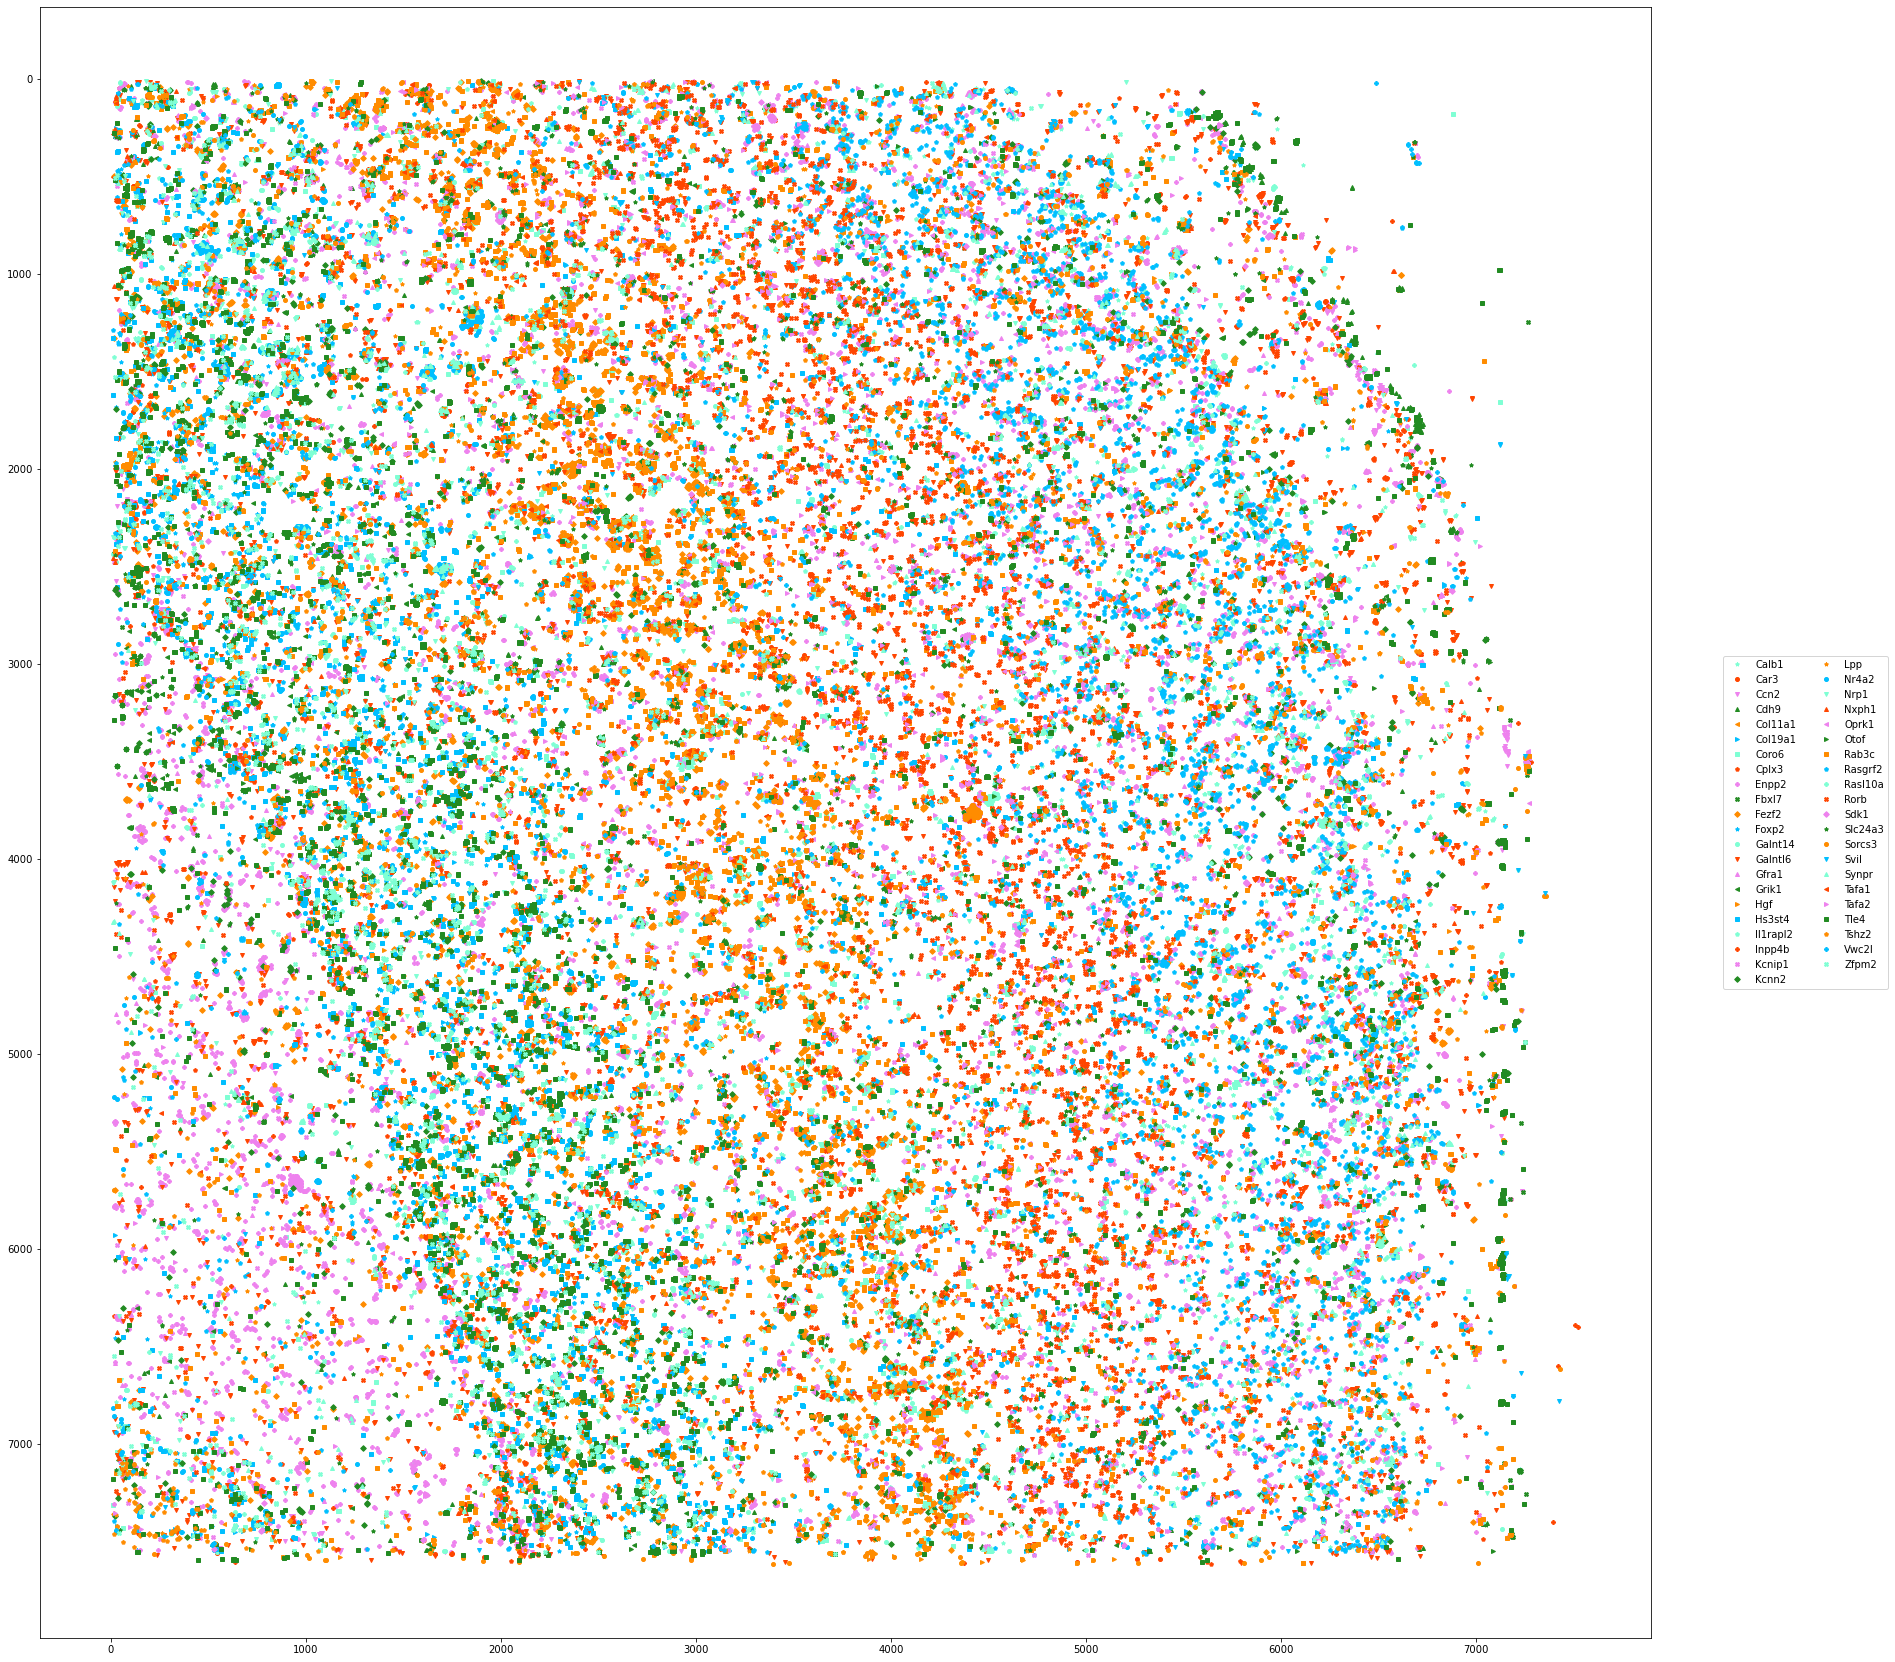

In [6]:
# Detect and plot genes
h = []
# filter pixels based on mean image values
s = np.mean(np.mean(stack, axis=3), axis=2)
g_filt = g.copy()
g_filt[s < 250] = 0
all_genes = []
for gene_idx, gene in enumerate(unique_genes):
    gene_spots = iss.segment.detect_gene_spots(g_filt[:, :, gene_idx], median_filter=True)
    all_genes.append(gene_spots)

plt.figure(figsize=(20, 40))
h = []
colors = cycle(['deepskyblue', 'aquamarine', 'orangered', 'violet', 'forestgreen', 'darkorange'])
markers = cycle('ov^<>spPXD*')

for gene_idx, gene in enumerate(unique_genes):
    ax = plt.subplot(10, 5, gene_idx + 1)
    plt.plot(all_genes[gene_idx]['x'], all_genes[gene_idx]['y'], next(markers), c=next(colors), markersize=2)
    plt.title(gene)
    ax.set_aspect('equal', 'box')
    ax.invert_yaxis()

plt.figure(figsize=(30, 30))
ax = plt.subplot(1, 1, 1)
h = []
for gene_idx, gene in enumerate(unique_genes):
    h.append(
        plt.plot(all_genes[gene_idx]['x'], all_genes[gene_idx]['y'], next(markers), c=next(colors), markersize=4)
    )
ax.set_aspect('equal', 'box')
ax.invert_yaxis()
plt.legend(unique_genes, loc='right', ncol=2, bbox_to_anchor=(0., 0., 1.15, 1.))

In [7]:
np.savez('/camp/lab/znamenskiyp/home/users/znamenp/tmp/genes.npz', g=g, unique_genes=unique_genes, all_genes=all_genes)

/camp/home/znamenp/.conda/envs/iss-preprocess/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [38]:
gene_df = gene_df[gene_df.sum(axis=1)>10]
gene_df.drop([0,])

Calb1  Car3  Ccn2  Cdh9  Col11a1  Col19a1  Coro6  Cplx3  Enpp2  Fbxl7  \
2       0.0   0.0   0.0   0.0      0.0      0.0    0.0    0.0    1.0    0.0   
3       1.0   0.0   0.0   0.0      0.0      0.0    0.0    0.0    7.0    0.0   
4       0.0   0.0   0.0   0.0      0.0      0.0    0.0    0.0    0.0    0.0   
6       1.0   0.0   0.0   0.0      0.0      0.0    0.0    0.0    0.0    0.0   
7       0.0   0.0   0.0   0.0      0.0      0.0    0.0    0.0    1.0    0.0   
...     ...   ...   ...   ...      ...      ...    ...    ...    ...    ...   
3521    0.0   0.0   2.0   0.0      0.0      0.0    0.0    1.0    0.0    1.0   
3522    0.0   0.0   0.0   0.0      0.0      0.0    0.0    0.0    0.0    0.0   
3524    0.0   0.0   0.0   0.0      0.0      1.0    0.0    0.0    5.0    0.0   
3525    0.0   0.0   0.0   2.0      0.0      2.0    2.0    1.0    0.0    0.0   
3533    0.0   0.0   0.0   0.0      0.0      0.0    0.0    0.0    0.0    0.0   

      ...  Slc24a3  Sorcs3  Svil  Synpr  Tafa1  Tafa2  Tle4  Tshz2  Vwc2l  \
2     ...      2.0     3.0   0.0    0.0    1.0    0.0   0.0    0.0    0.0   
3     ...      1.0     1.0   0.0    0.0    0.0    0.0   0.0    0.0    0.0   
4     ...      1.0     0.0   0.0    2.0    0.0    2.0   5.0    1.0    0.0   
6     ...      0.0     0.0   1.0    0.0    0.0    0.0   0.0    0.0    0.0   
7     ...      0.0     0.0   1.0    0.0    0.0    0.0   0.0    0.0    0.0   
...   ...      ...     ...   ...    ...    ...    ...   ...    ...    ...   
3521  ...      0.0     0.0   0.0    0.0    1.0    0.0   2.0    0.0    0.0   
3522  ...      0.0     2.0   0.0    0.0    0.0    0.0  10.0    0.0    0.0   
3524  ...      0.0     0.0   0.0    0.0    0.0    0.0   1.0    0.0    0.0   
3525  ...      0.0     0.0   0.0    0.0    0.0    1.0   0.0    0.0    0.0   
3533  ...      0.0     5.0   0.0    0.0    0.0    0.0   0.0    0.0    0.0   

      Zfpm2  
2       0.0  
3       0.0  
4       0.0  
6       0.0  
7       0.0  
...     ...  
3521    1.0  
3522    0.0  
3524    0.0  
3525    0.0  
3533    0.0  

[2037 rows x 43 columns]

In [ ]:
from scipy.cluster import hierarchy
gene_mat = np.log(1+gene_df.to_numpy())
Z = hierarchy.ward(gene_mat)
cell_order = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, gene_mat))

Z = hierarchy.ward(gene_mat.T)
gene_order = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, gene_mat.T))

In [ ]:
plt.figure(figsize=(20,10))
gene_mat_reordered = gene_mat[cell_order,:]
gene_mat_reordered = gene_mat_reordered[:,gene_order]
ax = plt.subplot(1,1,1)
plt.imshow(gene_mat_reordered, cmap='inferno', vmax=2, interpolation='nearest')
plt.xticks(range(gene_mat.shape[1]), gene_df.columns[gene_order], rotation=45)
ax.set_aspect('auto')


In [13]:
np.save('/camp/home/znamenp/home/users/znamenp/tmp/masks.npy', masks)

In [5]:
hyb_fname = '/camp/home/znamenp/home/shared/projects/rabies_BARseq/BRAC6246.1b/brain/slide_006/section_02/section_02_Hyb_probes.czi'

tiles, metadata = iss.io.get_tiles(hyb_fname)
tiles = iss.image.correct_offset(tiles, method='metadata', metadata=metadata)
stack_hyb, tile_pos = iss.reg.register_tiles(
    tiles,
    reg_fraction=ops['tile_reg_fraction'],
    method='custom',
    max_shift=20
)

stack_hyb = np.mean(stack_hyb, axis=3)

hyb_registered = iss.reg.register_rounds(
    [stack[:,:,0,:].squeeze(), stack_hyb[200:-3500,1000:-900,:]],
    ch_to_align=ops['ch_to_align'],
    filter_window='cosine',
    dog_filter=(10, 200)
)

hyb_registered = np.moveaxis(hyb_registered, 0, 2)
hyb_registered = iss.reg.register_rounds_fine(hyb_registered, tile_size=512)

hyb_registered = iss.image.correct_levels(
    [hyb_registered[:,:,1,:].squeeze(), ],
    hyb_registered[:,:,1,0],
    method='histogram'
)

In [6]:
iss.io.write_stack(
    hyb_registered[0],
    f'/camp/home/znamenp/home/users/znamenp/tmp/stack_hyb.tif'
)

In [12]:
dapi_fname = '/camp/home/znamenp/home/shared/projects/rabies_BARseq/BRAC6246.1b/brain/slide_006/section_02/DAPI_cycle_11.czi'
tiles, metadata = iss.io.get_tiles(dapi_fname)
tiles = iss.image.correct_offset(tiles, method='metadata', metadata=metadata)


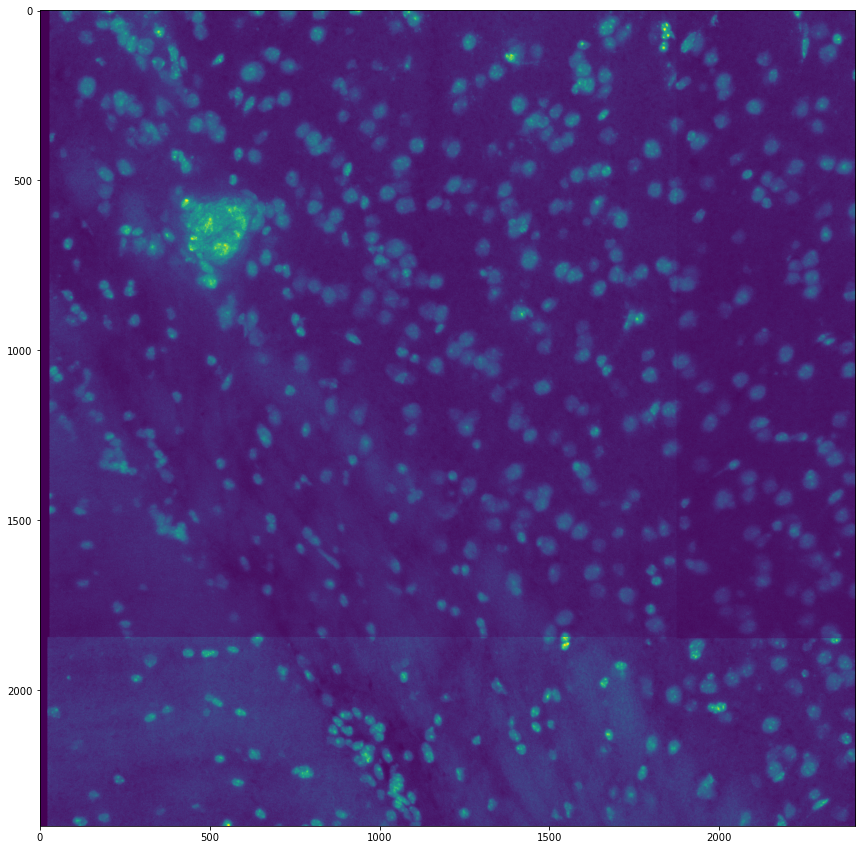

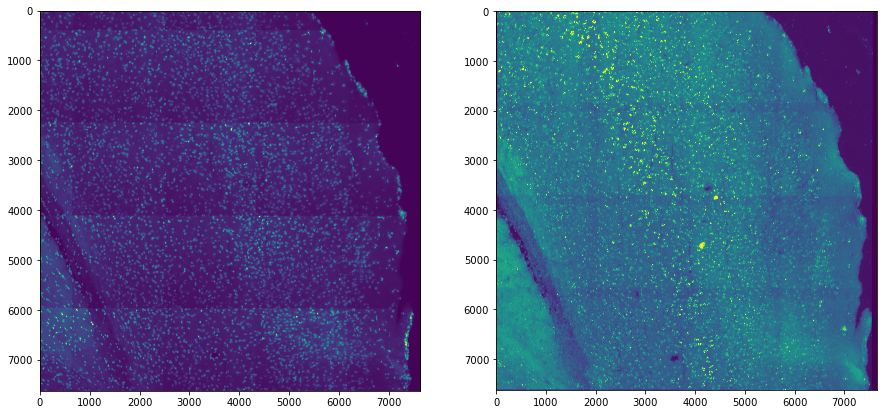

In [92]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(stack_dapi[1450:-400,3050:-600], vmax=2000)
plt.subplot(1,2,2)
plt.imshow(stack[:,:,0,0], vmax=2000)

In [116]:
stack_dapi, tile_pos = iss.reg.register_tiles(
    tiles,
    reg_fraction=0.1,
    method='custom',
    max_shift=20
)
stack_dapi = np.mean(stack_dapi, axis=3)

dapi_registered = iss.reg.register_rounds(
    [stack[:,:,0,0][:,:,np.newaxis], stack_dapi[1450:-400,3050:-600,:]],
    ch_to_align=ops['ch_to_align'],
    filter_window='cosine',
    dog_filter=(10, 200)
)
dapi_registered = np.moveaxis(dapi_registered, 0, 2)
dapi_registered = iss.reg.register_rounds_fine(dapi_registered, tile_size=512)

iss.io.write_stack(
    dapi_registered[1],
    '/camp/home/znamenp/home/users/znamenp/tmp/stack_dapi.tif'
)

In [105]:
stack[:,:,0,0][:,:,np.newaxis].shape

(7625, 7654, 1)

In [ ]:
masks = iss.segment.cellpose_segmentation(
    '/camp/home/znamenp/home/users/znamenp/tmp/stack_dapi.tif',
    channels=None,
    flow_threshold=2,
    vis=False,
    dilate_pix=0,
    rescale=0.55,
    model_type='nuclei'
)
cellpose.io.imsave('/camp/home/znamenp/home/users/znamenp/tmp/masks2.tif', masks)


2022-02-01 13:58:59,933 [INFO] >>nuclei<< model set to be used
2022-02-01 13:58:59,938 [INFO] >>>> using CPU
2022-02-01 13:59:00,142 [INFO] Evaluating with omni 0, cluster 0, flow_threshold 2.000000


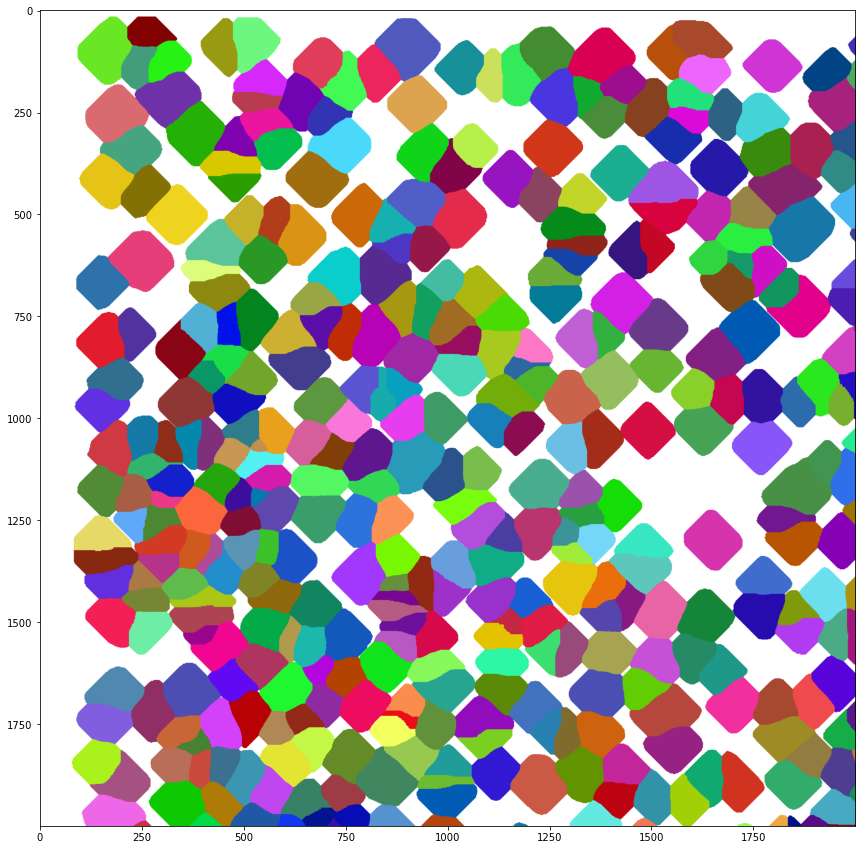

In [124]:
import cellpose
fig = plt.figure(figsize=(15,15))
plt.imshow(cellpose.plot.mask_rgb(masks[:2000,:2000]))
plt.show()

In [126]:
cellpose.io.imsave('/camp/home/znamenp/home/users/znamenp/tmp/masks.tif', masks)
np.save('/camp/home/znamenp/home/users/znamenp/tmp/masks2.npy', masks)


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.std(hyb_registered[0][:2000,:2000,:3], axis=2))

In [10]:
hyb_spots = iss.segment.detect_spots(
    hyb_registered[0][:,:,:3].squeeze(),
    method='trackpy',
    threshold=80
)
#iss.vis.plot_spots(hyb_registered[0][:2048,:2048,:3], hyb_spots)

In [12]:
hyb_rois = iss.call.extract_spots(hyb_spots, hyb_registered[0][:,:,np.newaxis,:3])

In [115]:
from sklearn.mixture import GaussianMixture
f = iss.call.rois_to_array(hyb_rois)
from sklearn.decomposition import FastICA
ica = FastICA(n_components=3, random_state=1, max_iter=1000).fit_transform(f[0,:,:].T)
gmm = GaussianMixture(n_components=3, random_state=0).fit(ica)
labels = gmm.predict(ica)
channel_id = np.array([
    np.argmax(np.mean(f[0,:,labels==label], axis=0)) for label in np.unique(labels)
])

spot_channels = channel_id[labels]

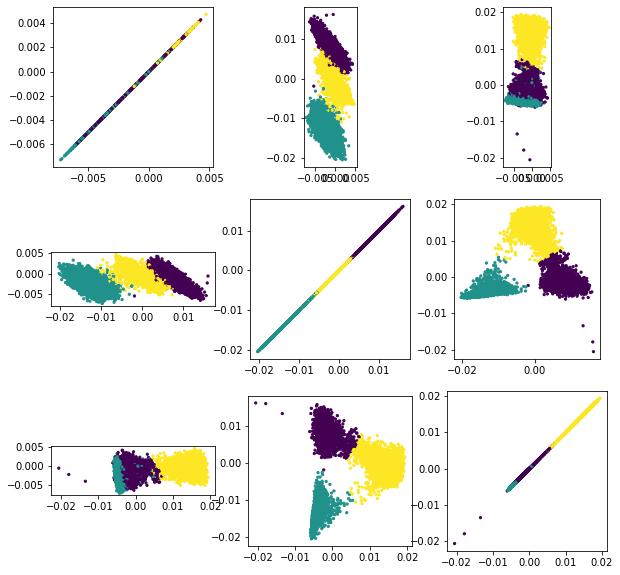

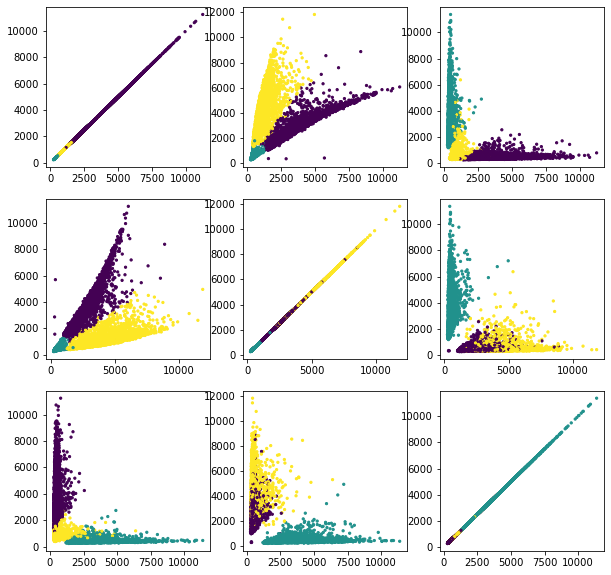

In [108]:
# visualise ICA components
plt.figure(figsize=(10,10))
for xch in range(f.shape[1]):
    for ych in range(f.shape[1]):
        ax = plt.subplot(f.shape[1], f.shape[1], xch*f.shape[1] + ych + 1)
        plt.scatter(ica[:,xch], ica[:,ych], c=labels, s=5)
        ax.set_aspect('equal')
# plot component assignments for the original fluorescence values
plt.figure(figsize=(10,10))
f = iss.call.rois_to_array(hyb_rois, normalize=False)
for xch in range(f.shape[1]):
    for ych in range(f.shape[1]):
        plt.subplot(f.shape[1], f.shape[1], xch*f.shape[1] + ych + 1)
        plt.scatter(f[:,xch], f[:,ych], c=labels, s=5)

In [121]:
fname = '/camp/lab/znamenskiyp/home/users/znamenp/tmp/genes.npz'
with np.load(fname, allow_pickle=True) as data:
    rolony_locations = data['all_genes'].tolist()
    gene_names = data['unique_genes'].tolist()

hyb_genes = ['Slc17a7', 'Slc30a3', 'Gad1']
for igene, gene in enumerate(hyb_genes):
    rolony_locations.append(hyb_spots[spot_channels==igene])
    gene_names.append(gene)

In [124]:
masks = np.load('/camp/home/znamenp/home/users/znamenp/tmp/masks.npy')

In [ ]:
gene_df

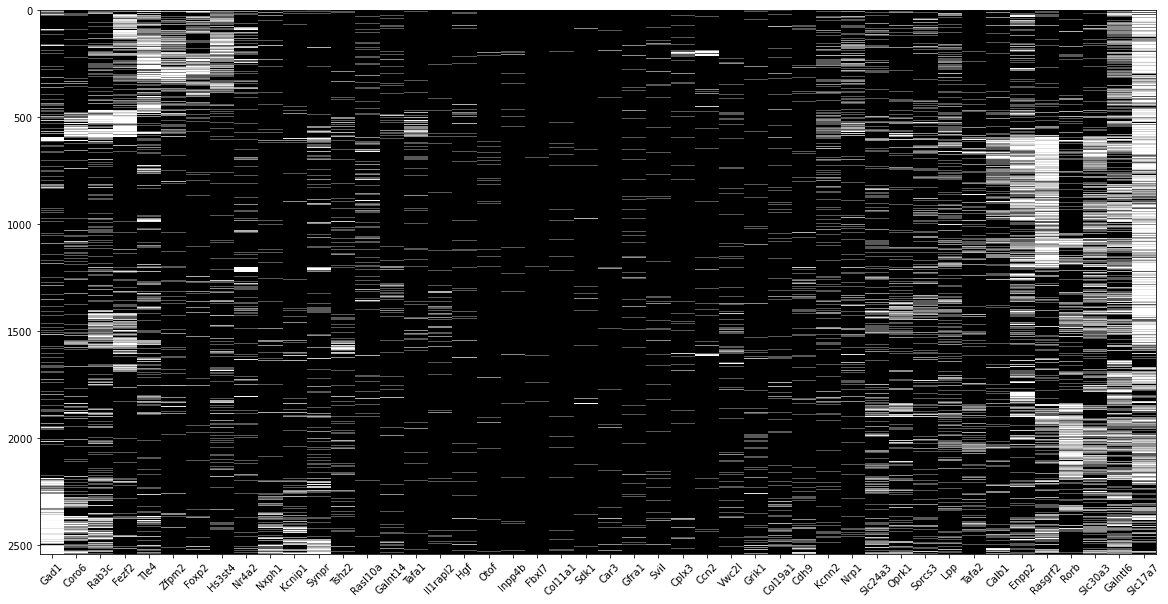

In [128]:
gene_df = iss.segment.count_rolonies(masks, rolony_locations, gene_names)
gene_df = gene_df[gene_df.sum(axis=1)>10]
gene_df.drop([0,])
iss.vis.plot_gene_matrix(gene_df)

In [129]:
np.savez(
    '/camp/lab/znamenskiyp/home/users/znamenp/tmp/genes2.npz',
    masks=masks,
    rolony_locations=rolony_locations,
    gene_names=gene_names
)

/camp/home/znamenp/.conda/envs/iss-preprocess/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
colors = cycle([ 'deepskyblue', 'aquamarine', 'orangered', 'violet', 'forestgreen', 'darkorange'])
markers = cycle('ov^<>spPXD*')
plt.figure(figsize=(30,30))
ax = plt.subplot(1,1,1)
h = []
for gene_idx, gene in enumerate(gene_names):
    h.append(
        plt.plot(rolony_locations[gene_idx]['x'], rolony_locations[gene_idx]['y'], next(markers), c=next(colors), markersize=4)
    )
ax.set_aspect('equal', 'box')
ax.invert_yaxis()
plt.legend(gene_names, loc='right', ncol=2, bbox_to_anchor=(0.,0.,1.15,1.))

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(np.std(hyb_registered[0][:2048,:2048,:], axis=2))

In [13]:
from itertools import compress

# rounds x channels x rois matrix
f = iss.call.rois_to_array(rois, normalize=False)
# only include ROIs imaged on all rounds
valid_rois = np.isfinite(f[0,0,:])
sequences = iss.call.basecall_rois(list(compress(rois, valid_rois)), separate_rounds=False, rounds=range(7))
f = f[:, :, valid_rois]
genes, errors = iss.call.call_genes(sequences, codebook)
errors = np.array(errors)
genes = np.array(genes)
# ignore spots that have too many mismatches
genes[errors > 0] = 'nan'
unique_genes = np.unique(genes)
unique_genes = unique_genes[unique_genes != 'nan']

f = np.moveaxis(f, 2, 0)
f = np.reshape(f, (f.shape[0], -1))
gene_dict = np.empty((f.shape[1], len(unique_genes)))
for igene, gene in enumerate(unique_genes):
    gene_dict[:, igene] = f[genes == gene, :].mean(axis=0)
gene_dict /= np.linalg.norm(gene_dict, axis=0)


            This normally occurs when an ROI is not imaged on all rounds.
            Corresponding values of the fluorescence matrix will be set to NaN.
            


In [17]:
from sklearn.mixture import GaussianMixture
def basecall_rois(rois, separate_rounds=True, rounds=(), nsamples=None):
    """
    Assign bases using a Gaussian Mixture Model.

    Args:
        rois (list): list of ROI objects.
        separate_rounds (bool): whether to run basecalling separately on each
            round or on all rounds together. Default True.
        rounds: numpy.array of rounds to include.
        nsamples (int): number of samples to include for fitting GMM. If None,
            all data are used for fitting. Default None.

    Returns:
        ROIs x rounds of base IDs.

    """
    def predict_bases(data_, nsamples_):
        if nsamples_ and nsamples_ < data.shape[0]:
            data_idx = np.random.choice(data_.shape[0], nsamples_, replace=False)
            gmm = GaussianMixture(n_components=4, random_state=0).fit(data_[data_idx, :])
        else:
            gmm = GaussianMixture(n_components=4, random_state=0).fit(data_)
        # GMM components are arbitrarily ordered. We assign each component to a
        # base based on its maximum channel.
        base_id = np.argmax(gmm.means_, axis=1) # the base id for each component
        base_means = gmm.means_[np.argsort(base_id), :]
        labels = gmm.predict(data_)
        return base_id[labels], base_means

    x = iss.call.rois_to_array(rois)
    if rounds:
        x = x[rounds,:,:]
    if separate_rounds:
        bases = np.empty((x.shape[2], x.shape[0]), dtype=int)
        base_means = np.empty(x.shape[1], x.shape[1], x.shape[0])
        for round in range(x.shape[0]):
            data = x[round,:,:].transpose()
            bases[:, round], base_means[:,:,round] = predict_bases(data, nsamples)
    else:
        data = np.moveaxis(x, 0, 2).reshape((4,-1)).transpose()
        bases, base_means = predict_bases(data, nsamples)
        bases = np.reshape(bases,(x.shape[2], x.shape[0]))

    return bases, base_means, x

In [21]:
bases, base_means, x = basecall_rois(list(compress(rois, valid_rois)), separate_rounds=False, rounds=range(1))

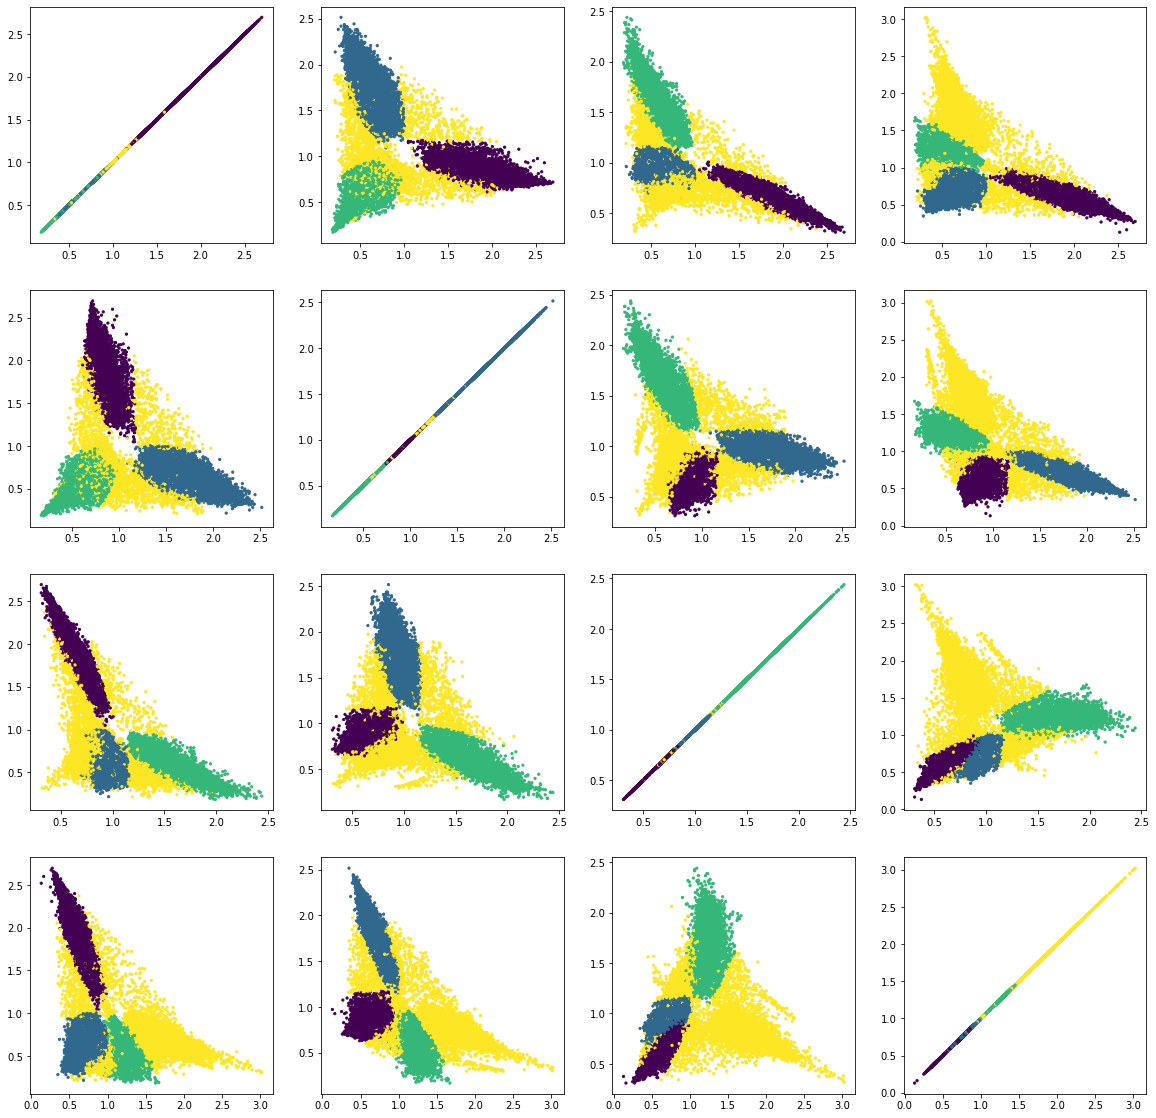

In [22]:
plt.figure(figsize=(20,20))
x = np.moveaxis(x, 2, 0)
x = np.reshape(x, (-1, 4))
for xch in range(x.shape[1]):
    for ych in range(x.shape[1]):
        plt.subplot(x.shape[1], x.shape[1], xch*x.shape[1] + ych + 1)
        plt.scatter(x[:,xch], x[:,ych], c=bases, s=5)

In [81]:
from pystackreg import StackReg
from skimage.filters import window, difference_of_gaussians

def register_rounds(stacks, ch_to_align=0, threshold=None, filter_window=None, dog_filter=None):
    """
    Register sequencing rounds.

    Args:
        stacks (list): list of X x Y x C ndarrays with individual rounds.
        ch_to_align(int): channel to use for registration.
        filter_window (str): whether to window the input images before registration.
            Example windows are 'cosine', 'blackman', and 'flattop'.
        dog_filter (tuple): whether to filter images with a difference-of-gaussians
            filter before registering. A tuple of `low_sigma` and `high_sigma`
            defining the range of spatial scales to bandpass.

    """
    maxx = 0
    maxy = 0
    for stack in stacks:
        maxx = np.max((maxx, stack.shape[0]))
        maxy = np.max((maxy, stack.shape[1]))
    nchannels = stacks[0].shape[2]
    for i, stack in enumerate(stacks):
        padx = maxx - stack.shape[0]
        pady = maxy - stack.shape[1]
        stacks[i] = np.pad(stack, ((0, padx), (0, pady), (0,0)), 'constant')

    stacks = np.stack(stacks, axis=0)
    if threshold:
        stacks[stacks<threshold] = 0

    sr = StackReg(StackReg.RIGID_BODY)
    stack_for_registration = stacks[:,:,:,ch_to_align].squeeze()
    if filter_window:
        w = window(filter_window, stacks.shape[1:3])[np.newaxis, :, :]
        stack_for_registration = stack_for_registration * w
    if dog_filter:
        stack_for_registration = difference_of_gaussians(
            stack_for_registration,
            low_sigma=dog_filter[0],
            high_sigma=dog_filter[1],
            channel_axis=0
        )
    sr.register_stack(stack_for_registration, reference='previous')

    for channel in range(nchannels):
        stacks[:,:,:,channel] = sr.transform_stack(stacks[:,:,:,channel].squeeze())

    return stacks